In [19]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from Models import ConvEncoder, ConvDecoder, TrAE, Classifier, TrVAE, VAE_loss
from Dataset import data_provider

from torch.utils.data import DataLoader

import time
import copy
from tqdm import tqdm

In [20]:
import easydict

args = easydict.EasyDict({
    'is_training': 1,
    'model': 'A', # ['A', 'B']
    ### data loader
    'root_path': './Data/',
    'data': '3D/new/',
    'data_path': 'csv/',
    'data_type': 'normal',
    'checkpoints': './checkpoints/',
    'Nsamples': 500, 
    'ratio': [7, 1, 2],
    ### forecasting task
    'seq_len': 2651, # [2144, 4576, 2651] # 3200 in paper
    'label_len': 100,
    'pred_len': 100,
    'class_num': 5,
    'individual': False,
    ### transformer
    'layer_num': 1,
    'dropout': 0.1,
    'max_len': 5000,
    'd_model': 512,
    'd_h': 8,
    'd_ff': 2048,
    ### Layers
    'layer_num': 5,
    'input_channel': 23,
    't': 128, 
    'output_channel': 23,
    'do_predict': True,
    ### optimization
    'num_workers': 8,
    'itr': 1,
    'train_epochs': 100,
    'batch_size': 64,
    'patience': 3,
    'lr': 0.005,
    ### GPU
    'device': 'cuda:0',
    'use_gpu': True,
    'multi_gpu': True,
})

args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(args.device)

if args.data == '2D/':
    args.data_path = ''
    args.seq_len = 3200  # 3200 in paper
    args.class_num = 4
    args.input_channel = 2
    args.t = 16
    args.output_channel = 4
    args.ratio = [3,1,1]
elif args.data == '3D/old/':
    args.data_path = ''
    args.seq_len = 4576
    args.input_channel = 3
    args.t = 64
    args.output_channel = 8
elif args.data == '3D/new/':
    args.input_channel = 3 # [3, 3, 3, 3, 3, 4, 4]
    args.t = 16
    args.output_channel = 4
    
if args.model == 'B':
    args.seq_len = 400
    
temp_data_type = args.data_type
args.data_type = 'normal'
normal_train_set, normal_train_loader = data_provider(args, 'train')
normal_train_C_set, normal_train_C_loader = data_provider(args, 'train_c')
args.data_type = 'mixed'
mixed_train_set, mixed_train_loader = data_provider(args, 'train')
mixed_train_C_set, mixed_train_C_loader = data_provider(args, 'train_c')

valid_set, valid_loader = data_provider(args, 'valid')
test_set, test_loader = data_provider(args, 'test')

normal_loaders = {'train': normal_train_loader, 'val': valid_loader, 'test': test_loader}
normal_C_loaders = {'train': normal_train_C_loader, 'val': valid_loader, 'test': test_loader}
mixed_loaders = {'train': mixed_train_loader, 'val': valid_loader, 'test': test_loader}
mixed_C_loaders = {'train': mixed_train_C_loader, 'val': valid_loader, 'test': test_loader}

cuda:0


## Data Preprocessing

### 2-Dimensional Trajectory

원본 .pickle 로드 및 전처리 후 .npy 저장

In [ ]:
import pickle
'''
Trajectory types: Normal, autopilot_lag, LOSrate_bias, LOSrate_delay
Target distance = uniform(4500, 5500)
states = [x, y, vm, path_angle] + 1 control input, 5 states
label = 0, 1, 2, 3 for normal, autopilot_lag, LOSrate_bias, LOSrate_delay respectively, 4 classes
minimum length of trajectory = 1360 (1360*0.01 = 13.6 seconds)
maximum length of trajectory = 2131 (2131*0.01 = 21.31 seconds)
fixed sequence length = 2144 (2400*0.01 = 24 seconds)
'''
start = time.time()
with open('Data/2D/Trajectories.pickle', 'rb') as f:
    Dataset = pickle.load(f)

# normal = Dataset['normal_PNG']
# lag = Dataset['autopilot_lag']
# bias = Dataset['LOSrate_bias']
# delay = Dataset['LOSrate_delay']
seq_len = 2144

label = 0
x = []
y = []
for tr_type in Dataset:
    states = Dataset[tr_type]['states']
    inputs = Dataset[tr_type]['actions']
    for i in range(len(states)):
        tr = np.concatenate((states[i], np.insert(inputs[i], 0, 0).reshape(-1 ,1)), axis=1)
        terminal = tr[-1].copy()
        terminal[2]=terminal[4]=0
        tr = np.concatenate((tr, np.tile(terminal, (seq_len-len(tr), 1))), axis=0)
        x.append(tr)
        y.append(label)
    label += 1
x = np.array(x)
y = np.array(y).reshape(-1, 1)
np.save('Data/2D/x.npy', x)
np.save('Data/2D/y.npy', y)
# x = np.load('Data/2D/x.npy')
# y = np.load('Data/2D/y.npy')
x.shape, y.shape, time.time()-start

.npy 로드

In [ ]:
x = np.load('Data/2D/x.npy')
y = np.load('Data/2D/y.npy')
x.shape, y.shape, time.time()-start

### 3-Dimentional Trajectory old version

원본 .pickle 로드 및 전처리 후 .npy 저장

In [ ]:
'''
Trajectory types: Normal, Burn time, Xcp position, Thrust Tilt Angle, Fin bias
Target Distance = 4000
States = ['Accm_1', 'Accm_2', 'Accm_3', 'angEuler_1', 'angEuler_2', 'angEuler_3', 'Rmi_1', 'Rmi_2', 'Rmi_3', 'Vmi_1', 'Vmi_2', 'Vmi_3', 'Accm_Cmd_1', 'Accm_Cmd_2', 'Accm_Cmd_3', 'PhiCmd'], 16 states
label = [0, 1, 2, 3, 4] for normal, burn_time, xcp_pos, thrust_tilt, fin_bias respectively, 5 classes
minimum length of trajectory = 412 (412*0.01 = 4.12 seconds)
maximum length of trajectory = 4569 (4569*0.01 = 45.69 seconds)
fixed sequence length = 4576 (4576*0.01 = 45.76 seconds)
'''
start = time.time()
seq_len = 4576
x = []
y = []

for i, tr_type in enumerate(['Normal', 'Burntime', 'Xcpposition', "ThrustTiltAngle", 'Finbias']):
    gid = pd.read_excel(f'Data/3D/old/Gid_{i+1}.xlsx', sheet_name=None)
    msl = pd.read_excel(f'Data/3D/old/Msl_{i+1}.xlsx', sheet_name=None)
    
    for sheet in gid:
        tr = pd.merge(msl[sheet][['Time', 'Rmi_1', 'Rmi_2', 'Rmi_3', 'Vmi_1', 'Vmi_2', 'Vmi_3', 'Accm_1', 'Accm_2', 'Accm_3', 'angEuler_1', 'angEuler_2', 'angEuler_3']], gid[sheet][['Time', 'Accm_Cmd_1', 'Accm_Cmd_2', 'Accm_Cmd_3', 'Phi_Cmd']]).to_numpy()[:, 1:]
        terminal = tr[-1].copy()
        terminal[3]=terminal[4]=terminal[5]=terminal[6]=terminal[7]=terminal[8]=terminal[12]=terminal[13]=terminal[14]=terminal[15]=0
        tr = np.concatenate((tr, np.tile(terminal, (seq_len-len(tr), 1))), axis=0)
        if sheet == 'Sheet1' and tr_type == 'Normal':
            x = [tr for _ in range(140)]
            y = [i for _ in range(140)]
        else:
            x.append(tr)
            y.append(i)

x = np.array(x)
y = np.array(y).reshape(-1, 1)
np.save('Data/3D/x_old.npy', x)
np.save('Data/3D/y_old.npy', y)
# x = np.load('Data/3D/x_old.npy')
# y = np.load('Data/3D/y_old.npy')
x.shape, y.shape, time.time()-start

.npy 로드

In [ ]:
start = time.time()
x = np.load('Data/3D/x_old.npy')
y = np.load('Data/3D/y_old.npy')
x.shape, y.shape, time.time()-start

### 3-Dimensional Trajectory new version

원본 .pickle 로드 및 전처리 후 .npy 저장

In [ ]:
'''
Trajectory types: Normal, Burn time, Xcp position, Thrust Tilt Angle, Fin bias
Target Distance = 4000
Total states = ['Rmi_1', 'Rmi_2', 'Rmi_3', 'Vmi_1', 'Vmi_2', 'Vmi_3', 'Wmb_1', 'Wmb_2', 'Wmb_3', 'Accm_1', 'Accm_2', 'Accm_3', 'angEuler_1', 'angEuler_2', 'angEuler_3', 'FinOut_1', 'FinOut_2', 'FinOut_3', 'FinOut_4', 'err_FinBias_1', 'err_FinBias_2', 'err_FinBias_3', 'err_FinBias_4', 'FinCmd_1', 'FinCmd_2', 'FinCmd_3', 'FinCmd_4', 'err_BurnTime', 'err_Tilt_1', 'err_Tilt_2', 'err_delXcp'], 31 states
Used States = ['Rmi_1', 'Rmi_2', 'Rmi_3', 'Vmi_1', 'Vmi_2', 'Vmi_3', 'Wmb_1', 'Wmb_2', 'Wmb_3', 'Accm_1', 'Accm_2', 'Accm_3', 'angEuler_1', 'angEuler_2', 'angEuler_3', 'FinOut_1', 'FinOut_2', 'FinOut_3', 'FinOut_4', 'FinCmd_1', 'FinCmd_2', 'FinCmd_3', 'FinCmd_4'], 23 states
label = [0, 1, 2, 3, 4] for normal, burn_time, xcp_pos, thrust_tilt, fin_bias respectively, 5 classes
minimum length of trajectory = 2449 (2448*0.01 = 24.48 seconds)
maximum length of trajectory = 2635 (2635*0.01 = 26.35 seconds)
fixed sequence length = 2656 (2656*0.01 = 26.56 seconds)
'''
start = time.time()
seq_len = 2656
x = []
y = []
tr = {}
for i, tr_type in enumerate(['Normal', 'Burntime', 'Xcpposition', "ThrustTiltAngle", 'Finbias']):
    N = 1 if i == 0 else 500
    for tr_i in range(N):
        tr = pd.read_csv(f'Data/3D/new/csv/Type_{i+1}_{tr_i+1}.csv', header=None)
        tr.columns = ['Rmi_1', 'Rmi_2', 'Rmi_3', 'Vmi_1', 'Vmi_2', 'Vmi_3', 'Wmb_1', 'Wmb_2', 'Wmb_3', 'Accm_1', 'Accm_2', 'Accm_3', 'angEuler_1', 'angEuler_2', 'angEuler_3', 'FinOut_1', 'FinOut_2', 'FinOut_3', 'FinOut_4', 'err_FinBias_1', 'err_FinBias_2', 'err_FinBias_3', 'err_FinBias_4', 'FinCmd_1', 'FinCmd_2', 'FinCmd_3', 'FinCmd_4', 'err_BurnTime', 'err_Tilt_1', 'err_Tilt_2', 'err_delXcp']
        tr = tr[['Rmi_1', 'Rmi_2', 'Rmi_3', 'Vmi_1', 'Vmi_2', 'Vmi_3', 'Wmb_1', 'Wmb_2', 'Wmb_3', 'Accm_1', 'Accm_2', 'Accm_3', 'angEuler_1', 'angEuler_2', 'angEuler_3', 'FinOut_1', 'FinOut_2', 'FinOut_3', 'FinOut_4', 'FinCmd_1', 'FinCmd_2', 'FinCmd_3', 'FinCmd_4']].to_numpy()
        tr[0] = 4000 - tr[0]
        terminal = tr[-1].copy()
        terminal[3]=terminal[4]=terminal[5]=terminal[6]=terminal[7]=terminal[8]=terminal[12]=terminal[13]=terminal[14]=terminal[19]=terminal[20]=terminal[21]=terminal[22]=0
        tr = np.concatenate((tr, np.tile(terminal, (seq_len-len(tr), 1))), axis=0)
        if i == 0:
            x = [tr for _ in range(500)]
            y = [i for _ in range(500)]
        else:
            x.append(tr)
            y.append(i)

x = np.array(x)
y = np.array(y).reshape(-1, 1)
np.save('Data/3D/x_new.npy', x)
np.save('Data/3D/y_new.npy', y)
# x = np.load('Data/3D/x_new.npy')
# y = np.load('Data/3D/y_new.npy')
x.shape, y.shape, time.time()-start

.npy 로드

In [ ]:
start = time.time()
x = np.load('Data/3D/x_new.npy')
y = np.load('Data/3D/y_new.npy')
x.shape, y.shape, time.time()-start

## Network Design

In [ ]:
temp_data_type = args.data_type
args.data_type = 'normal'
normal_train_set, normal_train_loader = data_provider(args, 'train')
normal_train_C_set, normal_train_C_loader = data_provider(args, 'train_c')
args.data_type = 'mixed'
mixed_train_set, mixed_train_loader = data_provider(args, 'train')
mixed_train_C_set, mixed_train_C_loader = data_provider(args, 'train_c')

valid_set, valid_loader = data_provider(args, 'valid')
test_set, test_loader = data_provider(args, 'test')

normal_loaders = {'train': normal_train_loader, 'val': valid_loader, 'test': test_loader}
normal_C_loaders = {'train': normal_train_C_loader, 'val': valid_loader, 'test': test_loader}
mixed_loaders = {'train': mixed_train_loader, 'val': valid_loader, 'test': test_loader}
mixed_C_loaders = {'train': mixed_train_C_loader, 'val': valid_loader, 'test': test_loader}

In [ ]:
model = TrAE(ConvEncoder, ConvDecoder, args).to(args.device)
criterion = nn.MSELoss().to(args.device)
optimizer = optim.Adam(model.parameters(), lr=args.lr)

In [21]:
def train_AutoEncoder(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10, phase = None, channel_type = None):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    if phase == 'before':
        ts = 0
    elif phase == 'initial':
        ts = 80
    elif phase == 'final':
        ts = 411
    else:
        ts = 0
    te = ts + args.seq_len
    
    if channel_type == 'Rmi':
        cs = 0
    elif channel_type == 'Vmi':
        cs = 3
    elif channel_type == 'Wmb':
        cs = 6
    elif channel_type == 'Accm':
        cs = 9
    elif channel_type == 'angEuler':
        cs = 12
    elif channel_type == 'FinOut':
        cs = 15
    elif channel_type == 'FinCmd':
        cs = 19
    else:
        cs = 0
    ce = cs + args.input_channel

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000
    
    epoch_iterater = tqdm(range(num_epochs), desc='AE Training', total=num_epochs)
    # since = time.time()
    for epoch in epoch_iterater:
        epoch_iterater.set_description('Epoch {}/{}'.format(epoch+1, num_epochs))

        for mode in ['train', 'val']:
            if mode == 'train':
                model.train()            # Set model to training mode
            else:
                model.eval()            # Set model to evaluate mode

            running_loss = 0.0
            for inputs, _ in dataloaders[mode]:
                inputs = inputs.to(args.device)[:, ts:te, cs:ce].type(torch.float32).transpose(1, 2)  # transfer inputs to GPU 
                optimizer.zero_grad()

                with torch.set_grad_enabled(mode == 'train'):
                    outputs, encoded = model(inputs)
                    loss = criterion(outputs, inputs)           # calculate a loss
                    if mode == 'train':
                        loss.backward()                             # perform back-propagation from the loss
                        optimizer.step()                             # perform gradient descent with given optimizer
                        scheduler.step()                             # update learning rate
                        
                running_loss += loss.item() * inputs.size(0)                    

            epoch_loss = running_loss / len(dataloaders[mode].dataset)
            # deep copy the model
            if mode == 'train':
                train_loss_history.append(epoch_loss)
            if mode == 'val':
                val_loss_history.append(epoch_loss)
            if mode == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
        epoch_iterater.set_postfix(f'{dataT} phase: {phases.index(phase)+1}/{len(phases)} states: {chTs.index(channel_type)+1}/{len(chTs)} train loss: {train_loss_history[-1]:.4f}, val loss: {val_loss_history[-1]:.4f}, best val loss: {best_val_loss:.4f}')

    # time_elapsed = time.time() - since
    # print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    # print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model, best_model_wts, train_loss_history, val_loss_history

mixed set Rmi featrue before phase Auto Encoder model training start


Epoch 1/100:   0%|          | 0/100 [00:01<?, ?it/s]


ValueError: need more than 1 value to unpack

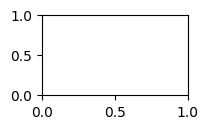

In [22]:
phases = ['before', 'initial', 'final'] if args.data == '3D/new/' else ['whole']
phase2len = {'before':96, 'initial':352, 'final':2240} if args.data == '3D/new/' else {'whole':3200}
chTs = ['Rmi', 'Vmi', 'Wmi', 'Accm', 'angEuler', 'FinOut', 'FinCmd'] if args.data == '3D/new/' else ['Rmi']
ch = {'Rmi':3, 'Vmi':3, 'Wmi':3, 'Accm':3, 'angEuler':3, 'FinOut':4, 'FinCmd':4} if args.data == '3D/new/' else {'Rmi':2}
plot_cnt = 0
temp_seq_len = args.seq_len

for dataT in ['mixed', 'normal']:
    # if dataT == 'normal':
    #     continue
    args.data_type = dataT
    # train_set, train_loader = data_provider(args, 'train')
    # valid_set, valid_loader = data_provider(args, 'valid')
    # test_set, test_loader = data_provider(args, 'test')
    # data_loaders = {'train': train_loader, 'val': valid_loader, 'test': test_loader}
    if dataT == 'mixed':
        data_loaders = mixed_loaders
    else:
        data_loaders = normal_loaders
    
    for phase in phases:
        plot_cnt += 1
        plt.subplot(4, len(phases), plot_cnt)
        for chT in chTs:
            if args.data == '3D/new/':
                args.seq_len = phase2len[phase]
                args.input_channel = ch[chT]
            save_ckpt = f'{args.checkpoints+args.data+args.model}_{args.data_type}_{chT}_{phase}_'
            print(f'{dataT} set {chT} featrue {phase} phase Auto Encoder model training start')
            model = TrAE(ConvEncoder, ConvDecoder, args).to(args.device)
            criterion = nn.MSELoss().to(args.device)
            optimizer = optim.Adam(model.parameters(), lr=args.lr)
            scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)
            
            trained_model, best_wts, train_loss_history, val_loss_history = train_AutoEncoder(model, data_loaders, criterion, optimizer, scheduler, args.train_epochs, phase, chT)
            torch.save(trained_model.state_dict(), save_ckpt+'model.pth')
            torch.save(trained_model.encoder.state_dict(), save_ckpt+'encoder.pth')
            trained_model.load_state_dict(best_wts)
            torch.save(trained_model.state_dict(), save_ckpt+'best_model.pth')
            torch.save(trained_model.encoder.state_dict(), save_ckpt+'best_encoder.pth')
            print('model saved to %s' % save_ckpt)
            
            plt.figure(figsize=(4, 3))
            plt.plot(train_loss_history, label=f'{phase} {chT} train')
            plt.plot(val_loss_history, label=f'{phase} {chT} val')
        #     break
        # break
    args.seq_len = temp_seq_len
    # break
plt.show()

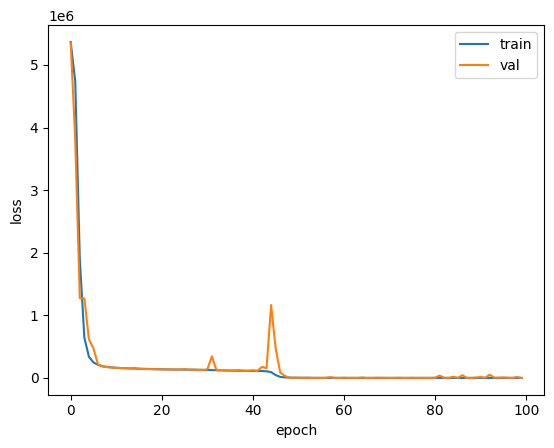

In [7]:
# Let's draw a learning curve like below.
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [8]:
with torch.no_grad():
    running_loss = 0.0
    for inputs, labels in data_loaders["test"]:
        inputs = inputs.to(args.device)[:, 0:96, :4].type(torch.float32).transpose(1, 2)

        outputs, encoded = trained_model(inputs)
        test_loss = criterion(outputs, inputs)
        
        running_loss += test_loss.item() * inputs.size(0)

    test_loss = running_loss / len(data_loaders["test"].dataset)
    print(test_loss)        

4150302.8733333335


In [ ]:
phases = ['before', 'initial', 'final'] if args.data == '3D/new/' else ['whole']
phase2len = {'before':96, 'initial':352, 'final':2240} if args.data == '3D/new/' else {'whole':3200}
chTs = ['Rmi', 'Vmi', 'Wmi', 'Accm', 'angEuler', 'FinOut', 'FinCmd'] if args.data == '3D/new/' else ['Rmi']
ch = {'Rmi':3, 'Vmi':3, 'Wmi':3, 'Accm':3, 'angEuler':3, 'FinOut':4, 'FinCmd':4} if args.data == '3D/new/' else {'Rmi':2}
plot_cnt = 0
temp_seq_len = args.seq_len

for dataT in ['mixed', 'normal']:
    # if dataT == 'normal':
    #     continue
    args.data_type = dataT
    # train_set, train_loader = data_provider(args, 'train')
    # valid_set, valid_loader = data_provider(args, 'valid')
    # test_set, test_loader = data_provider(args, 'test')
    # data_loaders = {'train': train_loader, 'val': valid_loader, 'test': test_loader}
    
    if dataT == 'mixed':
        data_loaders = mixed_loaders
    else:
        data_loaders = normal_loaders
    
    for phase in phases:
        plot_cnt += 1
        plt.subplot(4, len(phases), plot_cnt)
        for chT in chTs:
            args.seq_len = phase2len[phase]
            args.input_channel = ch[chT]
            for modelT in ['model', 'best_model']:
                save_ckpt = f'{args.checkpoints+args.data+args.model}_{args.data_type}_{chT}_{phase}_{modelT}'
                model = TrAE(ConvEncoder, ConvDecoder, args).to(args.device)
                model.load_state_dict(torch.load(save_ckpt+'.pth'))
                
                with torch.no_grad():
                    running_loss = 0.0
                    for inputs, labels in data_loaders["test"]:
                        inputs = inputs.to(args.device)[:,:,:2].type(torch.float32).transpose(1, 2)

                        # outputs, encoded = trained_model(inputs)
                        outputs, encoded = model(inputs)
                        test_loss = criterion(outputs, inputs)
                        
                        running_loss += test_loss.item() * inputs.size(0)

                    test_loss = running_loss / len(data_loaders["test"].dataset)
                    print(test_loss)

                tr = inputs.cpu().numpy()
                tr_hat = outputs.cpu().numpy()

                f, axes = plt.subplots(2, 5)
                f.set_size_inches((15, 5))
                plt.subplots_adjust(wspace = 0.3, hspace = 0.3)

                for i, n in enumerate(range(0, len(tr)-1, len(tr)//5)):
                    axes[0, i].plot(tr[n, 0, :], tr[n, 1, :])
                    # axes[0, i].plot(tr[n, 0, :])
                    # axes[0, i].plot(tr[n, 1, :])
                    axes[1, i].plot(tr_hat[n, 0, :], tr_hat[n, 1, :])
                    # axes[1, i].plot(tr_hat[n, 0, :])
                    # axes[1, i].plot(tr_hat[n, 1, :])

                plt.show()
        #         break
        #     break
        # break
    args.seq_len = temp_seq_len
    # break

In [ ]:
def train_classifier(encoder, model, dataloaders, criterion, optimizer, scheduler, num_epochs=10, phase = None, channel_type = None):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    if phase == 'before':
        ts = 0
    elif phase == 'initial':
        ts = 80
    elif phase == 'final':
        ts = 411
    else:
        ts = 0
    te = ts + args.seq_len
    
    if channel_type == 'Rmi':
        cs = 0
    elif channel_type == 'Vmi':
        cs = 3
    elif channel_type == 'Wmb':
        cs = 6
    elif channel_type == 'Accm':
        cs = 9
    elif channel_type == 'angEuler':
        cs = 12
    elif channel_type == 'FinOut':
        cs = 15
    elif channel_type == 'FinCmd':
        cs = 19
    else:
        cs = 0
    ce = cs + args.input_channel

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000

    encoder.eval()
    
    # since = time.time()
    epoch_iterater = tqdm(range(num_epochs), desc='C Training', total=num_epochs)
    for epoch in epoch_iterater:
        epoch_iterater.set_description('Epoch {}/{}'.format(epoch+1, num_epochs))

        for mode in ['train', 'val']:
            if mode == 'train':
                model.train()            # Set model to training mode
            else:
                model.eval()            # Set model to evaluate mode

            running_loss = 0.0
            for inputs, labels in dataloaders[mode]:
                inputs = inputs.to(args.device)[:, ts:te, cs:ce].type(torch.float32).transpose(1, 2)  # transfer inputs to GPU 
                encoded = encoder(inputs)
                labels = F.one_hot(labels, num_classes=args.class_num).to(args.device).type(torch.float32)
                optimizer.zero_grad()

                with torch.set_grad_enabled(mode == 'train'):
                    outputs = model(encoded.reshape(encoded.size(0), -1))  # forward pass
                    loss = criterion(outputs, labels)           # calculate a loss
                    loss = criterion(outputs.view(-1), labels.view(-1))
                    if mode == 'train':
                        loss.backward()                             # perform back-propagation from the loss
                        optimizer.step()                             # perform gradient descent with given optimizer
                        scheduler.step()                             # update learning rate
                        
                running_loss += loss.item() * inputs.size(0)                    

            epoch_loss = running_loss / len(dataloaders[mode].dataset)
            # print('{} Loss: {:.4f}'.format(mode, epoch_loss))
            
            # deep copy the model
            if mode == 'train':
                train_loss_history.append(epoch_loss)
            if mode == 'val':
                val_loss_history.append(epoch_loss)
            if mode == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
        epoch_iterater.set_postfix({'data':dataT, 'phase':f'{phases.index(phase)+1}/{len(phases)}', 'states': f'{chTs.index(channel_type)+1}/{len(chTs)}', 'loss':lossf[:-1],  'train loss': train_loss_history[-1], 'val loss': val_loss_history[-1], 'best val loss': best_val_loss})
        # print()

    # time_elapsed = time.time() - since
    # print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    # print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model, best_model_wts, train_loss_history, val_loss_history

In [23]:
phases = ['before', 'initial', 'final'] if args.data == '3D/new/' else ['whole']
phase2len = {'before':96, 'initial':352, 'final':2240} if args.data == '3D/new/' else {'whole':3200}
chTs = ['Rmi', 'Vmi', 'Wmi', 'Accm', 'angEuler', 'FinOut', 'FinCmd'] if args.data == '3D/new/' else ['Rmi']
ch = {'Rmi':3, 'Vmi':3, 'Wmi':3, 'Accm':3, 'angEuler':3, 'FinOut':4, 'FinCmd':4} if args.data == '3D/new/' else {'Rmi':2}
plot_cnt = 0
temp_seq_len = args.seq_len

for dataT in ['mixed', 'normal']:
    # if dataT == 'normal':
    #     continue
    args.seq_len = temp_seq_len
    args.data_type = dataT
    # train_set, train_loader = data_provider(args, 'train_c')
    # valid_set, valid_loader = data_provider(args, 'valid')
    # test_set, test_loader = data_provider(args, 'test')
    # data_loaders = {'train': train_loader, 'val': valid_loader, 'test': test_loader}
    if dataT == 'mixed':
        data_loaders = mixed_C_loaders
    else:
        data_loaders = normal_C_loaders
    
    for phase in phases:
        plot_cnt += 1
        plt.subplot(4, len(phases), plot_cnt)
        for chT in chTs:
            if args.data == '3D/new/':
                args.seq_len = phase2len[phase]
                args.input_channel = ch[chT]
            for lossf in ['MSE/', 'CE/']:
                if lossf == 'MSE/':
                    criterion = nn.MSELoss().to(args.device)
                else:
                    criterion = nn.CrossEntropyLoss().to(args.device)
                load_ckpt = f'{args.checkpoints+args.data+args.model}_{args.data_type}_{chT}_{phase}_'
                save_ckpt = f'{args.checkpoints+args.data+lossf+args.model}_{args.data_type}_{chT}_{phase}_'
                
                print(f'{dataT} set {chT} featrue {phase} phase {lossf[:-1]} loss Classifier model training start')
                encoder = ConvEncoder(args.input_channel, args.t, args.output_channel).to(args.device)
                encoder.load_state_dict(torch.load(load_ckpt+'encoder.pth'))
                model = Classifier(args.seq_len//(2**args.layer_num)*args.output_channel, args.class_num).to(args.device)
                optimizer = optim.Adam(model.parameters(), lr=args.lr)
                scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-5)
                
                trained_model, best_wts, train_loss_history, val_loss_history = train_classifier(encoder, model, data_loaders, criterion, optimizer, scheduler, args.train_epochs, phase, chT)
                torch.save(trained_model.state_dict(), save_ckpt+'classifier.pth')
                torch.save(best_wts, save_ckpt+'best_classifier.pth')
                print('model saved to %s' % save_ckpt)
                
                plt.figure(figsize=(4, 3))
                plt.plot(train_loss_history, label=f'{phase} {chT} train')
                plt.plot(val_loss_history, label=f'{phase} {chT} val')
        #     break
        # break
    args.seq_len = temp_seq_len
    # break
plt.show()

mixed set Rmi featrue before phase MSE loss Classifier model training start


Epoch 100/100: 100%|██████████| 100/100 [01:50<00:00,  1.10s/it, data=mixed, phase=1/3, states=1/7, loss=MSE, train loss=0.16, val loss=0.161, best val loss=0.149]


model saved to ./checkpoints/3D/new/MSE/A_mixed_Rmi_before_
mixed set Rmi featrue before phase CE loss Classifier model training start


Epoch 9/100:   8%|▊         | 8/100 [00:08<01:40,  1.09s/it, data=mixed, phase=1/3, states=1/7, loss=CE, train loss=1.61, val loss=1.64, best val loss=1.57]Exception ignored in: <function _releaseLock at 0x7fd8eed2d000>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/logging/__init__.py", line 228, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Epoch 20/100:  19%|█▉        | 19/100 [00:20<01:28,  1.10s/it, data=mixed, phase=1/3, states=1/7, loss=CE, train loss=1.61, val loss=1.61, best val loss=1.57]

In [9]:
next(iter(mixed_C_loaders['train']))[1]

tensor([3, 4, 2, 2, 3, 1, 3, 1, 4, 1, 1, 0, 0, 4, 3, 2, 2, 2, 4, 0, 4, 0, 2, 2,
        4, 2, 2, 1, 4, 0, 1, 1, 0, 1, 0, 4, 3, 2, 3, 2, 1, 4, 3, 4, 2, 4, 0, 0,
        1, 3, 2, 3, 4, 2, 1, 3, 3, 2, 1, 0, 1, 2, 3, 4])

In [16]:
F.one_hot(next(iter(mixed_C_loaders['train']))[1], num_classes=args.class_num).shape, model(encoder(next(iter(mixed_C_loaders['train']))[0][:,:96,:3].to(args.device).transpose(1,2).type(torch.float32)).reshape(64, -1)).shape

(torch.Size([64, 5]), torch.Size([64, 5]))

In [18]:
model(encoder(next(iter(mixed_C_loaders['train']))[0][:,:96,:3].to(args.device).transpose(1,2).type(torch.float32)).reshape(64, -1))

tensor([[0.0175, 0.0351, 0.0154, 0.0103, 0.0289],
        [0.0175, 0.0351, 0.0154, 0.0103, 0.0289],
        [0.0175, 0.0351, 0.0154, 0.0103, 0.0289],
        [0.0175, 0.0351, 0.0154, 0.0103, 0.0289],
        [0.0175, 0.0351, 0.0154, 0.0103, 0.0289],
        [0.0175, 0.0351, 0.0154, 0.0103, 0.0289],
        [0.0175, 0.0351, 0.0154, 0.0103, 0.0289],
        [0.0175, 0.0351, 0.0154, 0.0103, 0.0289],
        [0.0175, 0.0351, 0.0154, 0.0103, 0.0289],
        [0.0175, 0.0351, 0.0154, 0.0103, 0.0289],
        [0.0175, 0.0351, 0.0154, 0.0103, 0.0289],
        [0.0175, 0.0351, 0.0154, 0.0103, 0.0289],
        [0.0175, 0.0351, 0.0154, 0.0103, 0.0289],
        [0.0175, 0.0351, 0.0154, 0.0103, 0.0289],
        [0.0175, 0.0351, 0.0154, 0.0103, 0.0289],
        [0.0175, 0.0351, 0.0154, 0.0103, 0.0289],
        [0.0175, 0.0351, 0.0154, 0.0103, 0.0289],
        [0.0175, 0.0351, 0.0154, 0.0103, 0.0289],
        [0.0175, 0.0351, 0.0154, 0.0103, 0.0289],
        [0.0175, 0.0351, 0.0154, 0.0103, 0.0289],


In [14]:
args.seq_len = 2651

In [6]:
from sklearn.metrics import roc_auc_score, average_precision_score

phases = ['before', 'initial', 'final'] if args.data == '3D/new/' else ['whole']
phase2len = {'before':96, 'initial':352, 'final':2240} if args.data == '3D/new/' else {'whole':3200}
seq_start = {'before':0, 'initial':80, 'final':411} if args.data == '3D/new/' else {'whole':0}
chTs = ['Rmi', 'Vmi', 'Wmi', 'Accm', 'angEuler', 'FinOut', 'FinCmd'] if args.data == '3D/new/' else ['Rmi']
ch = {'Rmi':3, 'Vmi':3, 'Wmi':3, 'Accm':3, 'angEuler':3, 'FinOut':4, 'FinCmd':4} if args.data == '3D/new/' else {'Rmi':2}
channel_start = {'Rmi':0, 'Vmi':3, 'Wmi':6, 'Accm':9, 'angEuler':12, 'FinOut':15, 'FinCmd':19} if args.data == '3D/new/' else {'Rmi':0}
plot_cnt = 0
temp_seq_len = args.seq_len

for dataT in ['mixed', 'normal']:
    # if dataT == 'normal':
    #     continue
    args.seq_len = temp_seq_len
    args.data_type = dataT
    # train_set, train_loader = data_provider(args, 'train_c')
    # valid_set, valid_loader = data_provider(args, 'valid')
    # test_set, test_loader = data_provider(args, 'test')
    # data_loaders = {'train': train_loader, 'val': valid_loader, 'test': test_loader}
    if dataT == 'mixed':
        data_loaders = mixed_C_loaders
    else:
        data_loaders = normal_C_loaders
    
    for phase in phases:
        for chT in chTs:
            if args.data == '3D/new/':
                args.seq_len = phase2len[phase]
                args.input_channel = ch[chT]
            for lossf in ['MSE/', 'CE/']:
                if lossf == 'MSE/':
                    criterion = nn.MSELoss().to(args.device)
                else:
                    criterion = nn.CrossEntropyLoss().to(args.device)
                encoder_ckpt = f'{args.checkpoints+args.data+args.model}_{args.data_type}_{chT}_{phase}_'
                classifier_ckpt = f'{args.checkpoints+args.data+lossf+args.model}_{args.data_type}_{chT}_{phase}_'
                
                ts = seq_start[phase]
                te = ts + args.seq_len
                cs = channel_start[chT]
                ce = cs + args.input_channel
                
                for classifierT in ['', 'best_']:
                    encoder = ConvEncoder(args.input_channel, args.t, args.output_channel).to(args.device)
                    encoder.load_state_dict(torch.load(encoder_ckpt+'encoder.pth'))
                    classifier = Classifier(args.seq_len//(2**args.layer_num)*args.output_channel, args.class_num).to(args.device)
                    classifier.load_state_dict(torch.load(classifier_ckpt+classifierT+'classifier.pth'))
                    
                    correct = 0
                    total = 0

                    with torch.no_grad():
                        for inputs, labels in data_loaders["test"]:
                            inputs = inputs.to(args.device)[:,ts:te,cs:ce].type(torch.float32).transpose(1, 2)
                            labels_onehot = F.one_hot(labels, num_classes=args.class_num).to(args.device).type(torch.float32)
                            labels = labels.to(args.device).type(torch.float32)

                            hidden = encoder(inputs)
                            outputs = classifier(hidden.reshape(hidden.size(0), -1)).type(torch.float32)
                            
                            total += labels.size(0)
                            correct += (outputs.argmax(1) == labels).sum().item()
                    print(args.data_type, classifierT+'classifier', lossf)
                    print('Accuracy:', correct/total * 100, '%')
            break
        break
    args.seq_len = temp_seq_len
    break

mixed classifier MSE/
Accuracy: 13.333333333333334 %
mixed best_classifier MSE/
Accuracy: 46.666666666666664 %
mixed classifier CE/
Accuracy: 13.333333333333334 %
mixed best_classifier CE/
Accuracy: 46.666666666666664 %


In [17]:
outputs.argmax(1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       device='cuda:0')

In [18]:
outputs

tensor([[1.9903, 0.9199, 0.9947, 0.4194, 1.0879],
        [1.9900, 0.9199, 0.9946, 0.4191, 1.0881],
        [1.9903, 0.9199, 0.9947, 0.4194, 1.0879],
        [1.9901, 0.9199, 0.9946, 0.4191, 1.0881],
        [1.9903, 0.9199, 0.9948, 0.4194, 1.0879],
        [1.9903, 0.9199, 0.9947, 0.4194, 1.0879],
        [1.9902, 0.9199, 0.9947, 0.4192, 1.0880],
        [1.9903, 0.9199, 0.9947, 0.4194, 1.0879],
        [1.9903, 0.9199, 0.9947, 0.4194, 1.0879],
        [1.9903, 0.9199, 0.9947, 0.4194, 1.0879],
        [1.9902, 0.9199, 0.9947, 0.4192, 1.0880],
        [1.9903, 0.9199, 0.9947, 0.4194, 1.0879],
        [1.9904, 0.9199, 0.9948, 0.4195, 1.0879],
        [1.9903, 0.9205, 0.9946, 0.4193, 1.0887],
        [1.9895, 0.9200, 0.9944, 0.4183, 1.0884],
        [1.9903, 0.9199, 0.9947, 0.4194, 1.0879],
        [1.9895, 0.9200, 0.9943, 0.4182, 1.0884],
        [1.9902, 0.9199, 0.9947, 0.4192, 1.0880],
        [1.9902, 0.9199, 0.9947, 0.4193, 1.0880],
        [1.9900, 0.9199, 0.9946, 0.4191, 1.0881],


In [19]:
labels

tensor([0., 2., 0., 2., 3., 0., 3., 0., 0., 0., 3., 0., 3., 4., 1., 0., 1., 3.,
        3., 2., 3., 0., 0., 2., 0., 0., 0., 1., 1., 4., 0., 0., 2., 4., 4., 0.,
        2., 1., 0., 3., 3., 3., 3., 1., 0., 0.], device='cuda:0')

In [20]:
labels_onehot

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 1., 0., 0.],
        [0., 0., 0., 1., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0